In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, r2_score
from sklearn.decomposition import PCA

import requests
from bs4 import BeautifulSoup

import pickle
import time

In [2]:
testinc = pd.read_csv('../data/testinc.csv')

In [3]:
testinc.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)

## EDA

In [3]:
testinc = pd.read_csv('../data/testinc.csv')

In [5]:
testinc.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)

In [8]:
pd.set_option('display.max_columns', 30)
testinc.head()

,townstate,poverty,med_income,hs_completion,n_households,population,density,crime_rate,property_crime,violent_crime,students_per_teacher,gini,lat,lng,unemployment_rate,home_price,crime_rate_pc,vcrime_rate_pc,pcrime_rate_pc,people_per_household,state,preds,residuals
0,"Abbeville, Alabama",20.7,40186.0,79.1,2555,6055,12.2,62.0,51.0,11.0,13.000000,0.46135,31.60296,-85.21630,4.58761,86264.0,0.010239,0.001817,0.008423,2.369863,Alabama,103106.017089,16842.017089
1,"Abbeville, Louisiana",31.5,47483.0,70.7,9292,25897,42.4,591.0,474.0,117.0,14.875000,0.46135,29.89813,-92.19967,4.58761,129370.0,0.022821,0.004518,0.018303,2.787021,Louisiana,132736.201408,3366.201408
2,"Abbeville, South Carolina",39.9,34292.0,75.3,4925,13006,19.9,229.0,199.0,30.0,14.600000,0.46135,34.17875,-82.42871,4.58761,128638.0,0.017607,0.002307,0.015301,2.640812,South Carolina,92940.060425,-35697.939575
3,"Aberdeen, Idaho",13.8,43793.0,61.3,1127,3533,5.0,22.0,21.0,1.0,20.000000,0.46135,43.01939,-112.86185,4.58761,128794.0,0.006227,0.000283,0.005944,3.134871,Idaho,158927.403319,30133.403319
4,"Aberdeen, Maryland",17.2,60489.0,88.0,9538,24453,277.6,330.0,251.0,79.0,12.285714,0.41070,39.51075,-76.20061,3.70000,213991.0,0.013495,0.003231,0.010265,2.563745,Maryland,204127.397598,-9863.602402


In [9]:
testinc.shape

(5371, 23)

In [13]:
testinc.groupby('state')['home_price'].mean().sort_values(ascending = False)

state
California        638755.593795
Massachusetts     420776.786667
Colorado          355102.721739
Washington        337721.055556
New Jersey        324878.091837
Utah              283143.575472
Oregon            280570.450495
Rhode Island      268545.300000
Alaska            266152.428571
Delaware          264252.826087
New York          247544.200000
Maryland          238300.601020
Montana           230502.833333
New Hampshire     230246.611111
Vermont           226422.142857
Nevada            226274.000000
Idaho             218002.000000
Arizona           214539.974638
Wyoming           208555.014286
Florida           202430.890457
Connecticut       190669.200000
Minnesota         182972.162437
Virginia          176966.982514
Maine             174311.809524
Wisconsin         169828.382353
North Dakota      168942.580645
North Carolina    161164.392202
South Dakota      159249.511628
Ohio              158543.055195
Michigan          155510.718647
Texas             154365.137045
In

In [16]:
# No DC or HI
len(testinc['state'].value_counts())

49

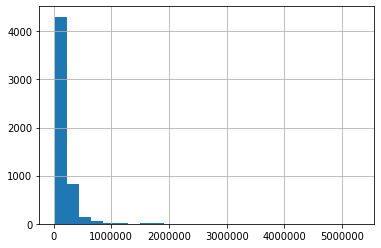

In [20]:
testinc['home_price'].hist(bins = 25)

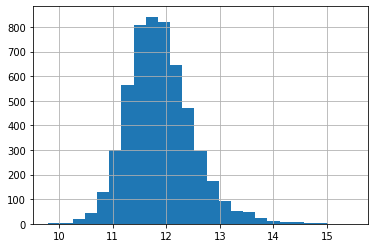

In [21]:
np.log(testinc['home_price']).hist(bins = 25)

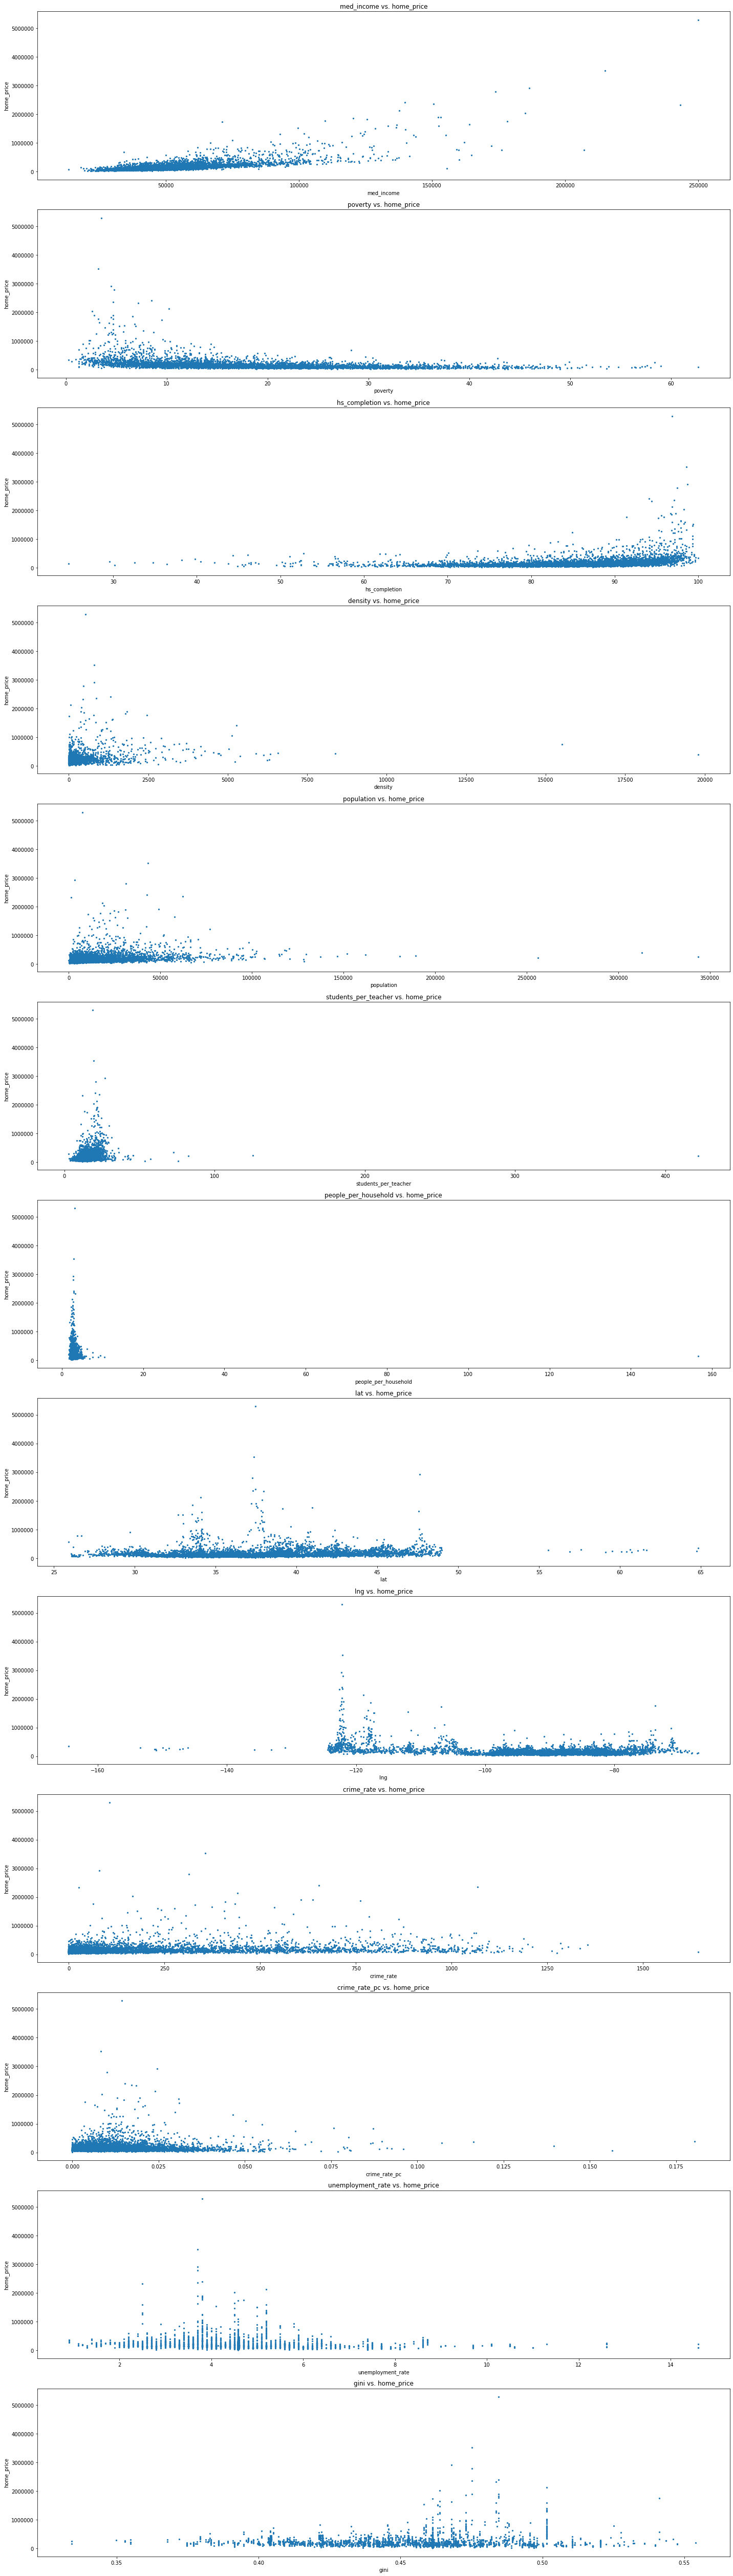

In [38]:
features = [
    'med_income',
    'poverty',
    'hs_completion',
    'density',
    'population',
    'students_per_teacher',
    'people_per_household',
    'lat',
    'lng',
    'crime_rate',
    'crime_rate_pc',
    'unemployment_rate',
    'gini',
]

fig, ax = plt.subplots(
    nrows = len(features), 
    ncols = 1, 
    sharey = 'all', 
    figsize = (20,70)
)

for i, feat in enumerate(features):
    ax[i].scatter(
        x = testinc[feat],
        y = testinc['home_price'],
        s = 5
    )
    
    ax[i].set_xlabel(f'{feat}')
    ax[i].set_ylabel('home_price')
    ax[i].set_title(f'{feat} vs. home_price')

plt.tight_layout()

In [39]:
testinc[features].corr()

,med_income,poverty,hs_completion,density,population,students_per_teacher,people_per_household,lat,lng,crime_rate,crime_rate_pc,unemployment_rate,gini
med_income,1.000000,-0.667322,0.521329,0.226592,0.327548,0.105823,0.013792,0.203964,-0.192430,0.135994,-0.094674,-0.217877,-0.122268
poverty,-0.667322,1.000000,-0.596651,-0.140821,-0.140142,-0.056780,0.000614,-0.282669,0.158545,-0.026673,0.080495,0.201973,0.147579
hs_completion,0.521329,-0.596651,1.000000,0.066058,0.152299,0.048625,-0.055075,0.376098,-0.021677,0.072495,-0.022981,-0.204912,-0.092610
density,0.226592,-0.140821,0.066058,1.000000,0.287677,0.071847,0.121895,0.026315,0.036621,0.301118,0.123181,-0.000372,0.135645
population,0.327548,-0.140142,0.152299,0.287677,1.000000,0.111295,0.016952,-0.062187,0.080163,0.655655,0.039584,-0.061357,-0.062801
students_per_teacher,0.105823,-0.056780,0.048625,0.071847,0.111295,1.000000,0.013946,0.070439,-0.166736,0.120092,0.052545,0.039557,-0.030480
people_per_household,0.013792,0.000614,-0.055075,0.121895,0.016952,0.013946,1.000000,-0.056086,-0.030330,0.011907,0.083046,0.018450,-0.010954
lat,0.203964,-0.282669,0.376098,0.026315,-0.062187,0.070439,-0.056086,1.000000,-0.246062,-0.056842,-0.062261,-0.129338,-0.130495
lng,-0.192430,0.158545,-0.021677,0.036621,0.080163,-0.166736,-0.030330,-0.246062,1.000000,0.001072,-0.074052,-0.061305,0.057097
crime_rate,0.135994,-0.026673,0.072495,0.301118,0.655655,0.120092,0.011907,-0.056842,0.001072,1.000000,0.531496,0.022658,-0.011981


## Modeling

### K Means Clustering

In [4]:
pd.set_option('display.max_columns', 35)
testinc.head()

,townstate,poverty,med_income,hs_completion,n_households,population,density,crime_rate,property_crime,violent_crime,students_per_teacher,gini,lat,lng,unemployment_rate,home_price,crime_rate_pc,vcrime_rate_pc,pcrime_rate_pc,people_per_household,state,preds,residuals
0,"Abbeville, Alabama",20.7,40186.0,79.1,2555,6055,12.2,62.0,51.0,11.0,13.000000,0.46135,31.60296,-85.21630,4.58761,86264.0,0.010239,0.001817,0.008423,2.369863,Alabama,103106.017089,16842.017089
1,"Abbeville, Louisiana",31.5,47483.0,70.7,9292,25897,42.4,591.0,474.0,117.0,14.875000,0.46135,29.89813,-92.19967,4.58761,129370.0,0.022821,0.004518,0.018303,2.787021,Louisiana,132736.201408,3366.201408
2,"Abbeville, South Carolina",39.9,34292.0,75.3,4925,13006,19.9,229.0,199.0,30.0,14.600000,0.46135,34.17875,-82.42871,4.58761,128638.0,0.017607,0.002307,0.015301,2.640812,South Carolina,92940.060425,-35697.939575
3,"Aberdeen, Idaho",13.8,43793.0,61.3,1127,3533,5.0,22.0,21.0,1.0,20.000000,0.46135,43.01939,-112.86185,4.58761,128794.0,0.006227,0.000283,0.005944,3.134871,Idaho,158927.403319,30133.403319
4,"Aberdeen, Maryland",17.2,60489.0,88.0,9538,24453,277.6,330.0,251.0,79.0,12.285714,0.41070,39.51075,-76.20061,3.70000,213991.0,0.013495,0.003231,0.010265,2.563745,Maryland,204127.397598,-9863.602402


In [5]:
testinc['log_density'] = np.log(testinc['density'])

In [6]:
features = [
    'med_income',
    'poverty',
    'hs_completion',
    'population',
    'density',
    'lat',
    'lng',
    #'log_density',
    'students_per_teacher',
    'gini',
    'crime_rate',
    'crime_rate_pc',
    'property_crime',
    'violent_crime',
    'unemployment_rate',
    'home_price'
]
X = testinc[features].copy()

In [7]:
X.corr()

,med_income,poverty,hs_completion,population,density,lat,lng,students_per_teacher,gini,crime_rate,crime_rate_pc,property_crime,violent_crime,unemployment_rate,home_price
med_income,1.000000,-0.667322,0.521329,0.327548,0.226592,0.203964,-0.192430,0.105823,-0.122268,0.135994,-0.094674,0.154220,-0.007289,-0.217877,0.715272
poverty,-0.667322,1.000000,-0.596651,-0.140142,-0.140821,-0.282669,0.158545,-0.056780,0.147579,-0.026673,0.080495,-0.045737,0.093062,0.201973,-0.357620
hs_completion,0.521329,-0.596651,1.000000,0.152299,0.066058,0.376098,-0.021677,0.048625,-0.092610,0.072495,-0.022981,0.093543,-0.070927,-0.204912,0.295034
population,0.327548,-0.140142,0.152299,1.000000,0.287677,-0.062187,0.080163,0.111295,-0.062801,0.655655,0.039584,0.653115,0.499741,-0.061357,0.234210
density,0.226592,-0.140821,0.066058,0.287677,1.000000,0.026315,0.036621,0.071847,0.135645,0.301118,0.123181,0.290070,0.287974,-0.000372,0.284547
lat,0.203964,-0.282669,0.376098,-0.062187,0.026315,1.000000,-0.246062,0.070439,-0.130495,-0.056842,-0.062261,-0.050012,-0.082430,-0.129338,0.097298
lng,-0.192430,0.158545,-0.021677,0.080163,0.036621,-0.246062,1.000000,-0.166736,0.057097,0.001072,-0.074052,-0.005918,0.042143,-0.061305,-0.341005
students_per_teacher,0.105823,-0.056780,0.048625,0.111295,0.071847,0.070439,-0.166736,1.000000,-0.030480,0.120092,0.052545,0.122078,0.077034,0.039557,0.149454
gini,-0.122268,0.147579,-0.092610,-0.062801,0.135645,-0.130495,0.057097,-0.030480,1.000000,-0.011981,0.028268,-0.023485,0.059198,0.265483,0.014598
crime_rate,0.135994,-0.026673,0.072495,0.655655,0.301118,-0.056842,0.001072,0.120092,-0.011981,1.000000,0.531496,0.994242,0.773357,0.022658,0.175484


In [8]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [9]:
km = KMeans(n_clusters = 2, random_state = 42)

In [10]:
km.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [11]:
testinc['cluster'] = km.labels_

In [12]:
centroids = testinc.groupby('cluster')[features].mean()
centroids.T

cluster,0,1
med_income,50131.416991,61773.124949
poverty,18.930562,16.456916
hs_completion,84.440810,87.289388
population,8913.701921,35149.411765
density,76.738927,538.410105
lat,37.991461,37.620970
lng,-92.408172,-94.007546
students_per_teacher,15.088422,17.504096
gini,0.457146,0.456076
crime_rate,94.644055,613.724960


In [85]:
ss.inverse_transform(km.cluster_centers_)

array([[ 5.01314170e+04,  1.89305616e+01,  8.44408096e+01,
         8.91370192e+03,  7.67389274e+01,  3.79914607e+01,
        -9.24081720e+01,  1.50884221e+01,  4.57145944e-01,
         9.46440554e+01,  1.07618113e-02,  8.44536834e+01,
         1.01903720e+01,  4.55233400e+00,  1.51580640e+05],
       [ 6.17731249e+04,  1.64569157e+01,  8.72893879e+01,
         3.51494118e+04,  5.38410105e+02,  3.76209702e+01,
        -9.40075461e+01,  1.75040964e+01,  4.56075846e-01,
         6.13724960e+02,  2.36531266e-02,  5.45242448e+02,
         6.84825119e+01,  4.55132239e+00,  2.87721328e+05]])

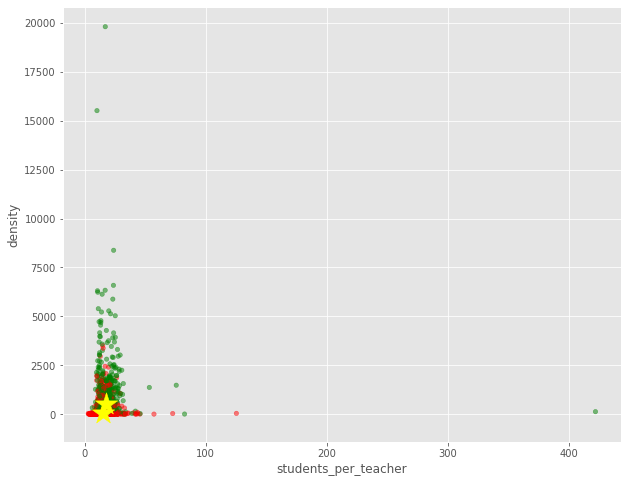

In [90]:
colors = ['red', 'green']
testinc['color'] = testinc['cluster'].map(lambda p: colors[p])

axis_1 = 'students_per_teacher'
axis_2 = 'density'

ax = testinc.plot(    
    kind = 'scatter', 
    x = axis_1, y = axis_2,
    figsize = (10,8),
    alpha = .5,
    c = testinc['color']
)

centroids.plot(
    kind = 'scatter', 
    x = axis_1, y = axis_2, 
    marker = '*', c = 'yellow', s = 550,
    ax = ax
);

In [88]:
silhouette_score(X_scaled, km.labels_)

0.32541856959720616

In [127]:
scores = []
for k in range(2, 30):
    cl = KMeans(n_clusters = k, random_state = 42)
    cl.fit(X_scaled)
    inertia = cl.inertia_
    sil = silhouette_score(X_scaled, cl.labels_)
    scores.append((k, inertia, sil))

In [128]:
score_df = pd.DataFrame(scores, columns = ['k', 'inertia', 'sil'])
score_df.head()

,k,inertia,sil
0,2,55414.006188,0.363376
1,3,49229.350610,0.184653
2,4,44994.607122,0.171310
3,5,41800.322747,0.172641
4,6,39859.293797,0.171408


### Regression

In [4]:
pd.set_option('display.max_columns', 35)
testinc.head()

,townstate,poverty,med_income,hs_completion,n_households,population,density,crime_rate,property_crime,violent_crime,students_per_teacher,gini,lat,lng,unemployment_rate,home_price,crime_rate_pc,vcrime_rate_pc,pcrime_rate_pc,people_per_household,state,preds,residuals
0,"Abbeville, Alabama",20.7,40186.0,79.1,2555,6055,12.2,62.0,51.0,11.0,13.000000,0.46135,31.60296,-85.21630,4.58761,86264.0,0.010239,0.001817,0.008423,2.369863,Alabama,103106.017089,16842.017089
1,"Abbeville, Louisiana",31.5,47483.0,70.7,9292,25897,42.4,591.0,474.0,117.0,14.875000,0.46135,29.89813,-92.19967,4.58761,129370.0,0.022821,0.004518,0.018303,2.787021,Louisiana,132736.201408,3366.201408
2,"Abbeville, South Carolina",39.9,34292.0,75.3,4925,13006,19.9,229.0,199.0,30.0,14.600000,0.46135,34.17875,-82.42871,4.58761,128638.0,0.017607,0.002307,0.015301,2.640812,South Carolina,92940.060425,-35697.939575
3,"Aberdeen, Idaho",13.8,43793.0,61.3,1127,3533,5.0,22.0,21.0,1.0,20.000000,0.46135,43.01939,-112.86185,4.58761,128794.0,0.006227,0.000283,0.005944,3.134871,Idaho,158927.403319,30133.403319
4,"Aberdeen, Maryland",17.2,60489.0,88.0,9538,24453,277.6,330.0,251.0,79.0,12.285714,0.41070,39.51075,-76.20061,3.70000,213991.0,0.013495,0.003231,0.010265,2.563745,Maryland,204127.397598,-9863.602402


In [5]:
testinc.shape

(5371, 23)

In [5]:
features = [
    'med_income',
    'poverty',
    'hs_completion',
    'density',
    'population',
    'students_per_teacher',
    'people_per_household',
    'lat',
    'lng',
    'crime_rate',
    'crime_rate_pc',
    'unemployment_rate',
    'gini',
]
X = testinc[features]
y = np.log(testinc['home_price'])

In [6]:
# pf = PolynomialFeatures()
# X_poly = pf.fit_transform(X)
X_poly = X.copy()

In [7]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_poly)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42)

In [9]:
rf = RandomForestRegressor(max_depth = 8, n_estimators = 25, random_state = 6)
rf.fit(X_train, y_train)
#rf.score(X_test, y_test)
pred = np.exp(rf.predict(X_test))
r2_score(np.exp(y_test), pred)

0.8574114122892804

In [10]:
testinc['preds'] = np.exp(rf.predict(X_scaled))

In [11]:
testinc['residuals'] = testinc['preds'] - testinc['home_price']

In [12]:
testinc.head()

,townstate,poverty,med_income,hs_completion,n_households,population,density,crime_rate,property_crime,violent_crime,students_per_teacher,gini,lat,lng,unemployment_rate,home_price,crime_rate_pc,vcrime_rate_pc,pcrime_rate_pc,people_per_household,state,preds,residuals
0,"Abbeville, Alabama",20.7,40186.0,79.1,2555,6055,12.2,62.0,51.0,11.0,13.000000,0.46135,31.60296,-85.21630,4.58761,86264.0,0.010239,0.001817,0.008423,2.369863,Alabama,100488.604757,14224.604757
1,"Abbeville, Louisiana",31.5,47483.0,70.7,9292,25897,42.4,591.0,474.0,117.0,14.875000,0.46135,29.89813,-92.19967,4.58761,129370.0,0.022821,0.004518,0.018303,2.787021,Louisiana,132912.706469,3542.706469
2,"Abbeville, South Carolina",39.9,34292.0,75.3,4925,13006,19.9,229.0,199.0,30.0,14.600000,0.46135,34.17875,-82.42871,4.58761,128638.0,0.017607,0.002307,0.015301,2.640812,South Carolina,91059.603777,-37578.396223
3,"Aberdeen, Idaho",13.8,43793.0,61.3,1127,3533,5.0,22.0,21.0,1.0,20.000000,0.46135,43.01939,-112.86185,4.58761,128794.0,0.006227,0.000283,0.005944,3.134871,Idaho,152824.707616,24030.707616
4,"Aberdeen, Maryland",17.2,60489.0,88.0,9538,24453,277.6,330.0,251.0,79.0,12.285714,0.41070,39.51075,-76.20061,3.70000,213991.0,0.013495,0.003231,0.010265,2.563745,Maryland,203655.432063,-10335.567937


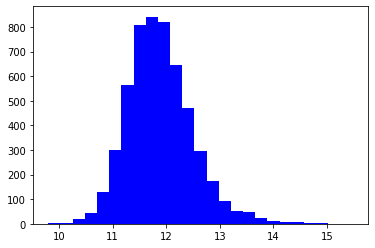

In [13]:
plt.hist(
    y, 
    bins = 25,
    color = 'blue'
);

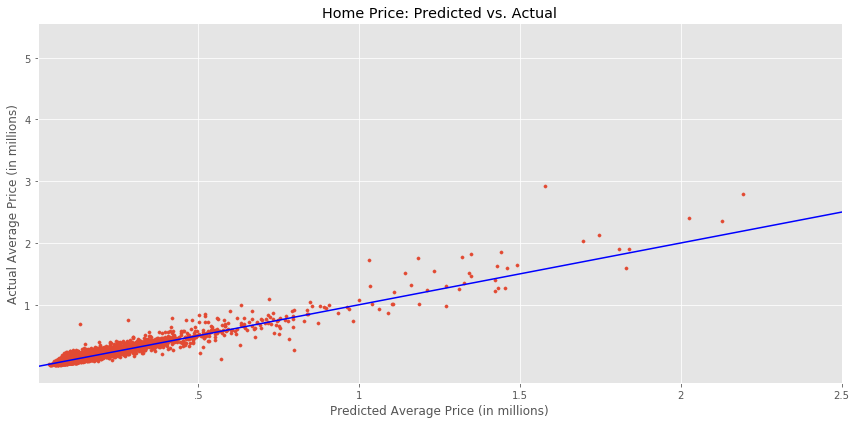

In [65]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))

plt.scatter(
    x = testinc['preds'],
    y = testinc['home_price'],
    s = 10,
    alpha = 1
)

plt.xlabel('Predicted Average Price (in millions)')
plt.ylabel('Actual Average Price (in millions)')

plt.xlim(0, 2_500_000)

plt.plot(
    np.linspace(0,2.5e6), 
    np.linspace(0,2.5e6), 
    c = 'blue',
    alpha = 1
)

plt.xticks(
    ticks = [500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000], #, 3_000_000, 3_500_000],
    labels = ['.5', '1', '1.5', '2', '2.5'] #, '3m', '3.5m']
)
plt.yticks(
    ticks = [1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000],
    labels = ['1', '2', '3', '4', '5']
)

plt.title('Home Price: Predicted vs. Actual')
plt.tight_layout()
plt.savefig('../plots/rf.png');

In [74]:
testinc.to_csv('../data/testinc.csv')

In [10]:
# pickle model
pickle.dump(rf, open("cap.pkl", "wb"))

In [39]:
### Feature importance ###
# Residuals, missing data
# Feature relationships (student ratio is proxy for density?), education proxy for income?
# Joining data sources
# Ratio of crime types
# Under budget police towns have big erros
# Can model fill in blanks for places with non reported crimes?

# Random forest vs. linear regression

In [ ]:
### EDA ###
# home price grouped by stuff #
# stuff vs home price #
# boxplot #

In [35]:
pd.Series(rf.feature_importances_, features).sort_values()

unemployment_rate       0.003355
crime_rate              0.003679
students_per_teacher    0.004392
gini                    0.005620
poverty                 0.006416
people_per_household    0.008927
crime_rate_pc           0.008944
hs_completion           0.011059
lat                     0.031189
population              0.040604
density                 0.044394
lng                     0.224846
med_income              0.606575
dtype: float64

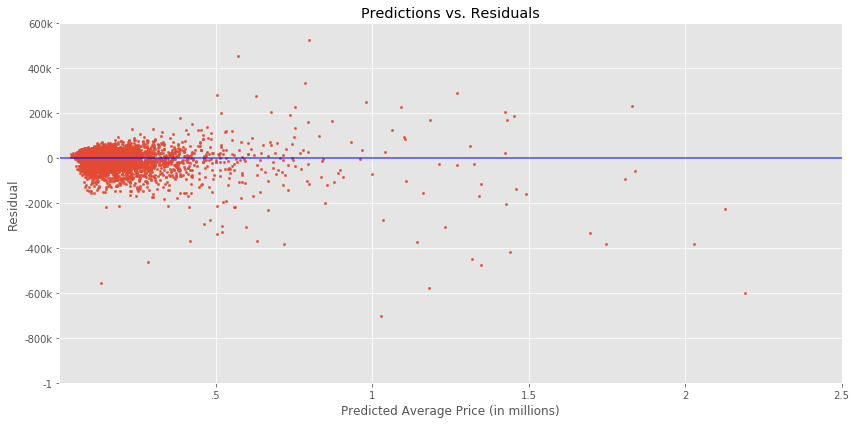

In [66]:
plt.figure(figsize = (12,6))

plt.scatter(
    x = testinc['preds'], 
    y = testinc['residuals'], 
    s = 5)

plt.xlim(0, 2_500_000)
plt.ylim(-1_000_000, 600_000)

plt.xlabel('Predicted Average Price (in millions)')
plt.ylabel('Residual')

plt.plot(
    np.linspace(0,2.5e6), 
    np.linspace(0, 0), 
    c = 'blue',
    alpha = .7
)

plt.xticks(
    ticks = [500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000], #, 3_000_000, 3_500_000],
    labels = ['.5', '1', '1.5', '2', '2.5'] #, '3m', '3.5m']
)
plt.yticks(
    ticks = [-1_000_000, -800_000, -600_000, -400_000, -200_000, 0, 200_000, 400_000, 600_000],
    labels = ['-1', '-800k', '-600k', '-400k', '-200k', '0', '200k', '400k', '600k']
)

plt.title('Predictions vs. Residuals')
plt.tight_layout()
plt.savefig('../plots/resid.png');

In [64]:
lr = LinearRegression()
lr.fit(X_train, y_train)
#lr.score(X_train, y_train), lr.score(X_test, y_test)
pred = np.exp(lr.predict(X_test))
r2_score(np.exp(y_test), pred)

-0.23372337808457067

In [59]:
pred = lr.predict(X_test)
r2_score(y_test, pred)

0.6355758611905622

In [60]:
rflr = pd.DataFrame(np.exp(lr.predict(X_test)), columns = ['lin_reg'])
rflr['ran_for'] = np.exp(rf.predict(X_test))
rflr['diff'] = rflr['lin_reg'] - rflr['ran_for']
rflr.head()

,lin_reg,ran_for,diff
0,106339.369609,97645.164853,8694.204756
1,113457.069146,114516.366533,-1059.297387
2,98166.717680,83162.298281,15004.419398
3,120272.218257,109127.132875,11145.085383
4,113316.787477,118988.566369,-5671.778892


In [56]:
rflr.sort_values(by = 'diff')

,lin_reg,ran_for,diff
818,6.181118e+05,1.276016e+06,-6.579040e+05
107,5.836839e+05,1.140244e+06,-5.565598e+05
308,2.375255e+05,7.649410e+05,-5.274156e+05
1011,7.353120e+05,1.222171e+06,-4.868588e+05
291,2.735443e+05,7.424220e+05,-4.688777e+05
...,...,...,...
451,1.503506e+06,4.740830e+05,1.029423e+06
444,1.530718e+06,4.422660e+05,1.088452e+06
762,2.945374e+06,1.489374e+06,1.456000e+06
20,3.501962e+06,4.604119e+05,3.041550e+06


In [62]:
cross_val_score(lr, X, y, cv = 5).mean()

0.6329399559217623

In [63]:
lr.coef_

array([ 0.36920365, -0.00608566,  0.04209934,  0.09325613,  0.0302751 ,
        0.0274148 , -0.03668776, -0.01504098, -0.15433573,  0.06128393,
       -0.0297573 , -0.01025537, -0.01853843])